# Traffic Sign Classification

In [1]:
!pip install -q visualkeras



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.models import load_model
import plotly
import warnings
from sklearn.model_selection import train_test_split
from PIL import Image
from keras.layers import Dense,Conv2D,MaxPooling2D,BatchNormalization,Flatten,Dropout
from keras.models import Sequential

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
plotly.offline.init_notebook_mode(True)

dataset_dir ="C:/Users/NURŞAH SATILMIŞ/Desktop/traffic sign"
meta_info = os.path.join(dataset_dir, 'germanDataset/Meta.csv')
train_csv_path = os.path.join(dataset_dir, 'germanDataset/Train.csv')
test_csv_path = os.path.join(dataset_dir, 'germanDataset/Test.csv')


In [2]:
# Defining all classes in dataset
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [3]:
#Accessing meta files in dataset
d={}
meta=os.path.join(dataset_dir,"germanDataset/Meta")
add=os.listdir(meta)
add.remove(".~lock.ClassesInformation.ods#")
add.remove(".~lock.ClassesInformationStrong.ods#")
for i in add:
    x=i.split(".")
    im=Image.open(meta+'/'+i)
    im=im.convert("RGB")
    im_arr=np.array(im)
    d[int(x[0])]=im_arr

In [4]:
# load data 
train_data_color = '#0f7b8e'
test_data_color = '#630f8e'

trainDf = pd.read_csv(train_csv_path)
testDf = pd.read_csv(test_csv_path)
metaDf = pd.read_csv(meta_info)


trainDf.sample(3)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
14078,33,35,6,6,28,30,9,Train/9/00009_00017_00008.png
4434,53,51,5,6,48,46,2,Train/2/00002_00054_00024.png
11269,40,41,5,5,35,36,7,Train/7/00007_00018_00019.png


## Preprocessing the Dataset
For successful training of our model, the images in our dataset need to satisfy certain criteria. These include:

Uniform Size: The images must all have the same dimensions to match the input requirements of the neural network model.
Normalization: The pixel values of the images should be normalized to fall within a specific range, typically between 0 and 1. This aids in speeding up the training process and achieving better performance.
We choose to work with either RGB (colored)

In [5]:
#Reading training data from train folder
x_data=[];y_data=[];new_size=(32,32)
ias=os.listdir(os.path.join(dataset_dir, "germanDataset/Train"))
for i in ias:
    train_img=os.listdir(os.path.join(dataset_dir, "germanDataset/Train"+"/"+i))
    for j in train_img:
        img1=Image.open(os.path.join(dataset_dir, "germanDataset/Train"+"/"+i+"/"+j))
        img1=img1.resize(new_size)
        a1=img1.convert("RGB")
        x_data.append(np.array(a1)) 
        y_data.append(int(i))

In [6]:
#Converting data to numpy array
x_data=np.array(x_data)
y_data=np.array(y_data)

In [7]:
print(x_data.shape,y_data.shape)


(39209, 32, 32, 3) (39209,)


In [8]:
dataset=pd.DataFrame(zip(x_data,y_data))
dataset.head()

,0,1
0,"[[[75, 78, 80], [73, 76, 78], [82, 84, 83], [9...",0
1,"[[[69, 73, 73], [76, 79, 79], [75, 77, 77], [7...",0
2,"[[[72, 72, 72], [79, 79, 79], [76, 78, 73], [1...",0
3,"[[[68, 67, 67], [75, 72, 73], [87, 81, 81], [1...",0
4,"[[[73, 73, 75], [74, 73, 75], [72, 71, 69], [1...",0


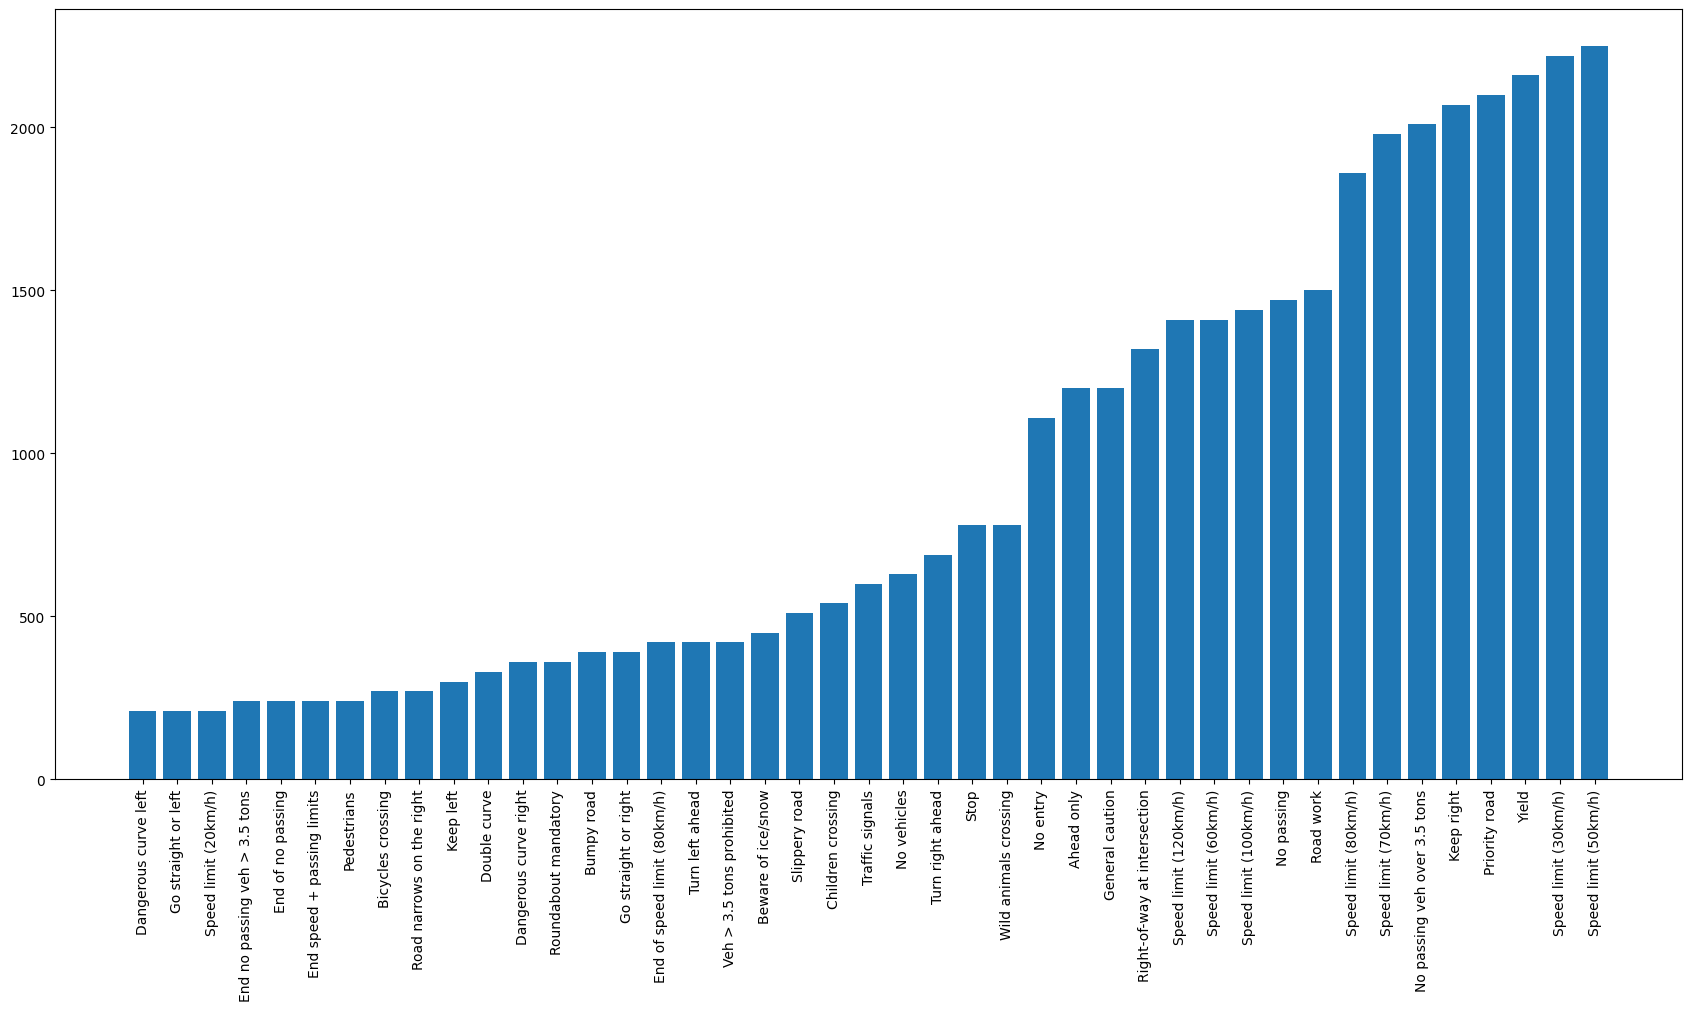

In [9]:
#Plotting no of samples in each class in sorted order

train_path = os.path.join(dataset_dir, "germanDataset/Train")
folders = os.listdir(train_path)
train_number = []
class_num = []
for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

In [15]:
x1_test=[];y1_test=[]
for i in range(testDf.shape[0]):
    test_path=os.path.join(dataset_dir,"germanDataset")
    img_test = Image.open(os.path.join(test_path, testDf.iloc[i, -1]))                 
    img_test=img_test.resize(new_size)
    img_test=img_test.convert("RGB")
    x1_test.append(np.array(img_test))  
    y1_test.append(testDf.iloc[i,6])

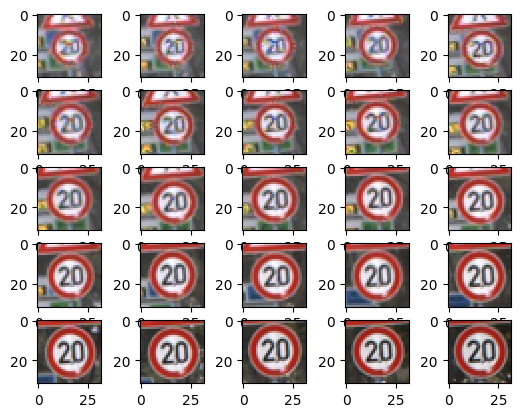

In [16]:
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(x_data[i])


In [17]:
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.2,shuffle=True)
x_train=x_train.astype("float32")/255
x_test=x_test.astype("float32")/255

# CNN

We built various basic CNN models. "GTSRB_classifier" is one of the successfull model. However , after add third convolutional layer (has 128 filters) 
we achive %96 accuracy. Therefore , ınstead of first model ımplementation , "GTSRB_classifier2" implemantation is  shown below.

In [ ]:
model=Sequential()
#define first convolutional layer with 32 filters of size 3x3
model.add(Conv2D(32,(3,3),input_shape=(32,32,3),activation='relu',padding="same"))

#second layer with 64 filters
model.add(Conv2D(64,(3,3),activation='relu',padding="same"))

#third layer with 128 filters
model.add(Conv2D(128,(3,3),activation='relu',padding="same"))

#drapout layer to prevent overfitting by  randomly setting 30% of the neurons to zero in each iteration
model.add(Dropout(0.3))

#Reduce the size of the output (help feature extraction)
model.add(MaxPooling2D())

#normalization to speed up and stability
model.add(BatchNormalization())

model.add(Conv2D(32,(3,3),activation='relu',padding="same"))
model.add(Conv2D(64,(3,3),activation='relu',padding="same"))
model.add(Conv2D(128,(3,3),activation='relu',padding="same"))

model.add(Dropout(0.3))
model.add(MaxPooling2D())
model.add(BatchNormalization())

# Flattens the output into a 1D vector to feed into the fully connected layers.
model.add(Flatten())

#Add a fully connected layer with 43 neurons (we have 43 classes)
model.add(Dense(units=43,activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 dropout_6 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Bat  (None, 16, 16, 64)        256       
 chNormalization)                                     

In [ ]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.05)
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=['accuracy'])

In [ ]:
hist=model.fit(x_train,y_train,epochs=10,batch_size=32,validation_split=0.2)

Epoch 1/10
785/785 [==============================] - 86s 106ms/step - loss: 2.6373 - accuracy: 0.4777 - val_loss: 1.8454 - val_accuracy: 0.6065
Epoch 2/10
785/785 [==============================] - 81s 103ms/step - loss: 2.7303 - accuracy: 0.7722 - val_loss: 11.8532 - val_accuracy: 0.7298
Epoch 3/10
785/785 [==============================] - 77s 98ms/step - loss: 2.0210 - accuracy: 0.8833 - val_loss: 5.6527 - val_accuracy: 0.8068
Epoch 4/10
785/785 [==============================] - 75s 96ms/step - loss: 2.1224 - accuracy: 0.9185 - val_loss: 2.3061 - val_accuracy: 0.9186
Epoch 5/10
785/785 [==============================] - 75s 95ms/step - loss: 3.9440 - accuracy: 0.9238 - val_loss: 2.3218 - val_accuracy: 0.9490
Epoch 6/10
785/785 [==============================] - 74s 94ms/step - loss: 2.1526 - accuracy: 0.9579 - val_loss: 3.1801 - val_accuracy: 0.9458
Epoch 7/10
785/785 [==============================] - 74s 95ms/step - loss: 2.1149 - accuracy: 0.9645 - val_loss: 2.1869 - val_accura

246/246 [==============================] - 5s 21ms/step


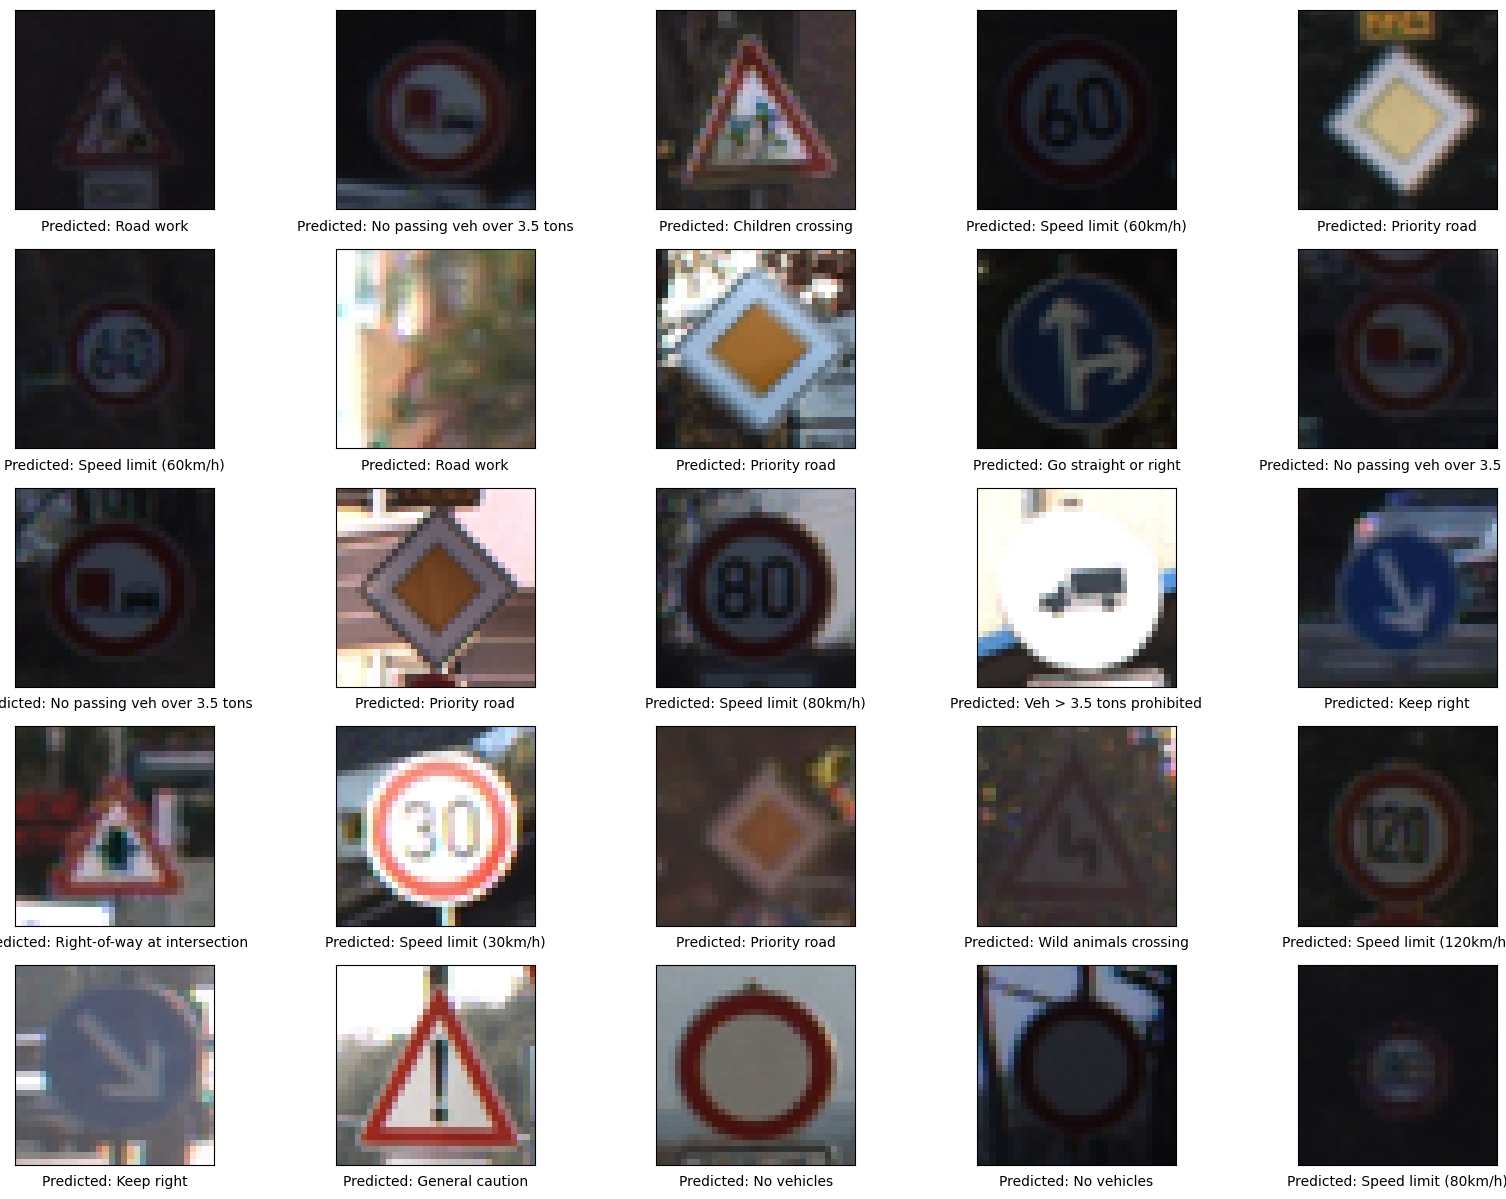

In [26]:
import matplotlib.pyplot as plt
import numpy as np

predictions = model.predict(x_test)
# Display some predicted images
plt.figure(figsize=(20, 15))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    predicted_label_index = np.argmax(predictions[i])  # Get the index of the highest probability
    predicted_label = classes[predicted_label_index]  # Get the class name from the classes dictionary
    plt.xlabel('Predicted: {}'.format(predicted_label))
plt.show()


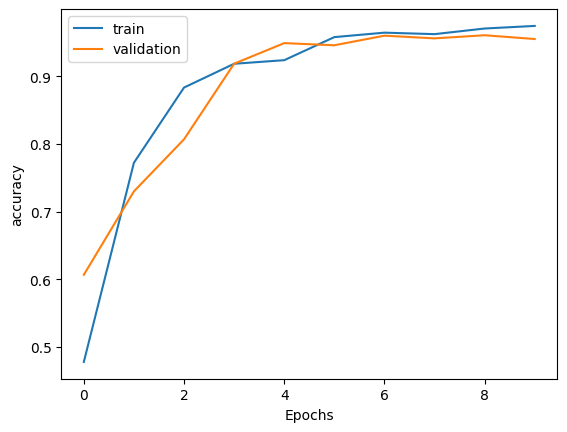

In [ ]:
plt.plot(hist.history["accuracy"],label="train")
plt.plot(hist.history["val_accuracy"],label="validation")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.legend()

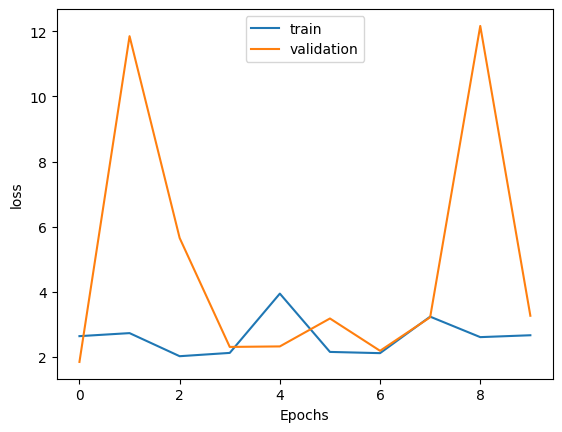

In [ ]:
plt.plot(hist.history['loss'],label='train')
plt.plot(hist.history['val_loss'],label="validation")
plt.ylabel('loss')
plt.xlabel("Epochs")
plt.legend()

In [ ]:
model.evaluate(x_test,y_test)

246/246 [==============================] - 6s 24ms/step - loss: 4.2170 - accuracy: 0.9535


[4.217000961303711, 0.9534557461738586]

In [ ]:
model.save('GTSRB_classifier2.keras')

## Test  with  Real Time Video Stream


In [19]:


# Load  CNN model
model = load_model('GTSRB_classifier2.keras')


# Function to preprocess the video frame
def preprocess_frame(frame):
    # Preprocess the frame (e.g., resize to 32x32 pixels, normalize pixel values)
    processed_frame = cv2.resize(frame, (32, 32))
    processed_frame = processed_frame.astype('float32') / 255.0
    return processed_frame

# Capture video from webcam
cap = cv2.VideoCapture(0)  # Change 0 to the index of your camera if you have multiple cameras

# Initialize an array to store the last N predictions
N = 5
prediction_history = []

while True:
    ret, frame = cap.read()  # Read a frame from the video

    # Preprocess the frame
    processed_frame = preprocess_frame(frame)

    # Reshape the frame to match the input shape expected by the model
    input_frame = np.expand_dims(processed_frame, axis=0)

    # Get the predicted class probabilities
    predictions = model.predict(input_frame)

    # Get the predicted class label
    predicted_class = np.argmax(predictions)

    # Add the prediction to the history
    prediction_history.append(predicted_class)

    # Keep only the last N predictions
    prediction_history = prediction_history[-N:]

    # Use the most common prediction in the history
    smoothed_prediction = max(set(prediction_history), key=prediction_history.count)

    # Get the corresponding sign name
    sign_name = classes.get(smoothed_prediction, "Unknown")

    # Display the frame and predicted sign name
    cv2.putText(frame, sign_name, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Traffic Sign Recognition', frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture
cap.release()
cv2.destroyAllWindows()




1/1 [==============================] - 0s 19ms/step
